In [116]:
import numpy as np
import cv2
from scipy.spatial import distance
from scipy.ndimage.filters import convolve
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import argparse
from argparse import RawTextHelpFormatter
import glob
from os import makedirs
from os.path import join, exists, basename, splitext
import cv2
import matplotlib.pyplot as plt


In [194]:
def init_kernel(image_config):
    kernel = np.zeros((image_config["size"],image_config["size"]))
    for i in range(image_config["size"]):
        for j in range(image_config["size"]):
            G_pq = (distance.euclidean((i, j), (image_config["size"] // 2, image_config["size"] // 2)) ** 2)
            sig2 = (spatial_sigma ** 2)
            kernel[i, j] = np.exp(-0.5 *G_pq / sig2)
    return kernel


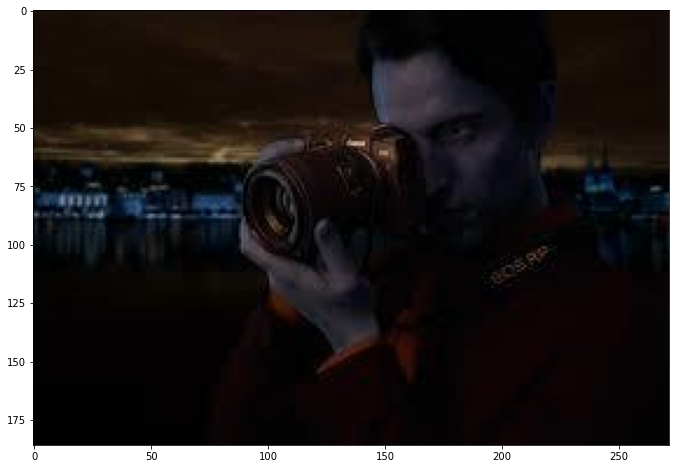

(15, 15)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


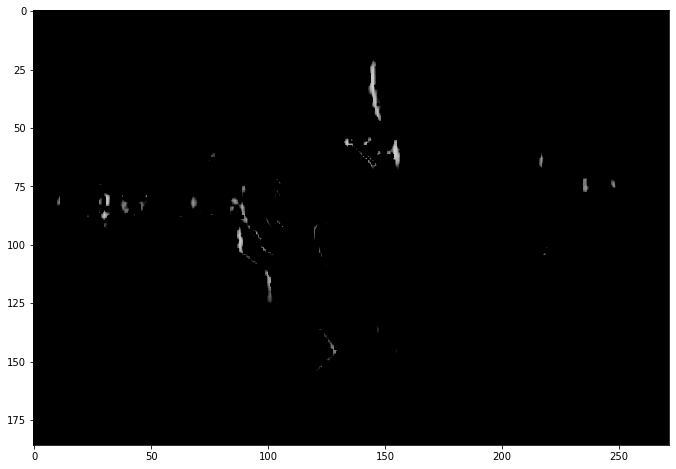

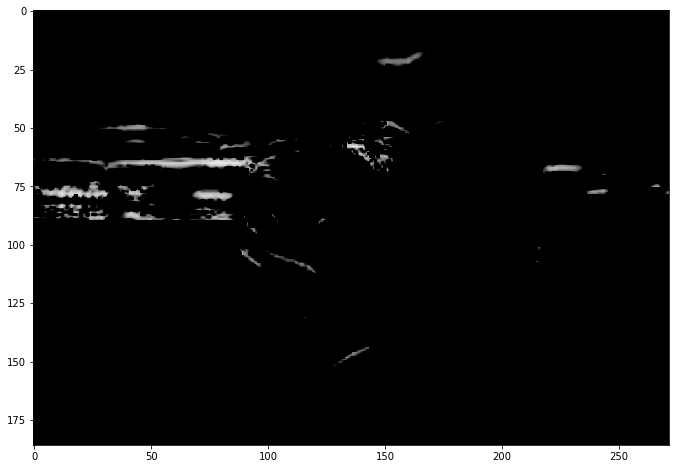

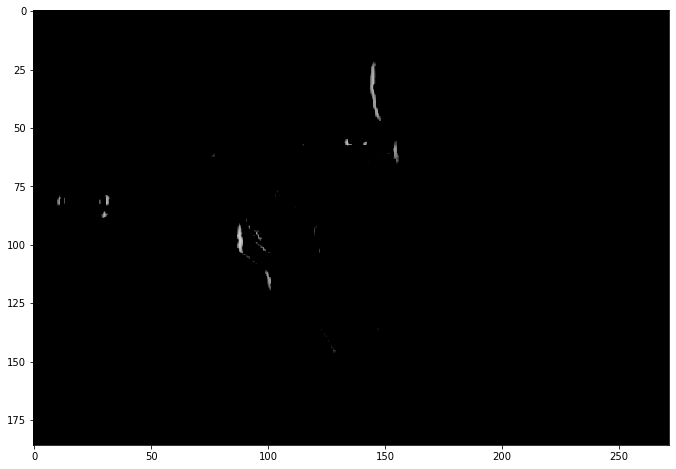

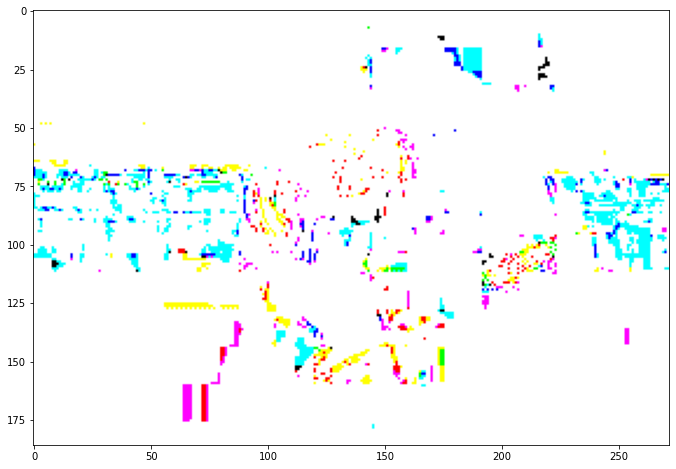

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


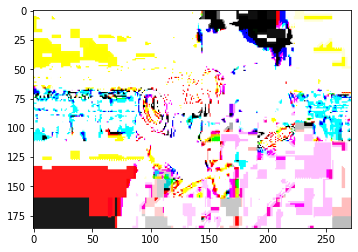

In [193]:
def correct_image():
    
    path="C:/Users/HP-PC/Downloads/Low-light-Image-Enhancement-master/ppt/"
    imgpath=path+"/img1.jpg"
    image = cv2.imread(imgpath)
    
    # create new directory for saving result
    directory = join(path, "improved")
    if not exists(directory):
        makedirs(directory)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    imgplot = plt.imshow(image)
    output_img=[]
    plt.show()
    enhanced_image = illuminate_image(image,image_config)
    name, ext = imgpath.split(".")
    
    
    cv2.imwrite(join(directory,"under_lamda"+"."+ext), enhanced_image)
    
correct_image()
    

In [192]:
#default values
image_config={"be":1.0,"bs":1.0,"bc":1.0}
image_config["size"]=15
image_config["sigma"]=3    #3
image_config["gamma"]=0.6
image_config["lamda"]=1 #0.15
image_config["eps"]=1e-3
print(image_config)

{'be': 1.0, 'bs': 1.0, 'bc': 1.0, 'size': 15, 'sigma': 3, 'gamma': 0.6, 'lamda': 1, 'eps': 0.001}


In [191]:
def improved_L_map(L, image_config):
    
    Lp = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=1)
    T = convolve(np.ones_like(L), kernel, mode='constant')
    T = T / (np.abs(convolve(Lp, kernel, mode='constant')) + image_config["eps"])
    wx=T / (np.abs(Lp) + image_config["eps"])
    wx1=255-wx
    plt.figure(figsize=(12, 8))
    imgplot = plt.imshow(wx1, cmap='gray', vmin=0, vmax=255)
    #plt.show()
    Lp = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=1)
    T = convolve(np.ones_like(L), kernel, mode='constant')
    T = T / (np.abs(convolve(Lp, kernel, mode='constant')) + image_config["eps"])
    wy=T / (np.abs(Lp) + image_config["eps"])
    
    wy1=255-wy
    plt.figure(figsize=(12, 8))
    imgplot = plt.imshow(wy1, cmap='gray', vmin=0, vmax=255)
    
    #plt.show()
    n, m = L.shape
    L_1d = L.copy().flatten()

    row, column, data = [], [], []
    for p in range(n * m):
        diag = 0
        for q, (k, l, x) in get_sparse_neighbor(p, n, m).items():
            weight = wx[k, l] if x else wy[k, l]
            row.append(p)
            column.append(q)
            data.append(-weight)
            diag += weight
        row.append(p)
        column.append(p)
        data.append(diag)
    F = csr_matrix((data, (row, column)), shape=(n * m, n * m))

    Id = diags([np.ones(n * m)], [0])
    A = Id + image_config["lamda"] * F
    L_refined = spsolve(csr_matrix(A), L_1d, permc_spec=None, use_umfpack=True).reshape((n, m))

    L_refined = np.clip(L_refined, image_config["eps"], 1) ** image_config["gamma"]

    return L_refined

In [190]:
def forward_illumination(im,image_config):
    L = np.max(im, axis=-1)
    L_refined = improved_L_map(L, image_config)
    L_refined_3d = np.repeat(L_refined[..., None], 3, axis=-1)
    im_corrected = im / L_refined_3d
    return im_corrected

In [189]:
def illuminate_image(image,image_config):
    kernel=init_kernel(image_config)
    print(kernel.shape)
    image_config["kernel"]=kernel
    im_normalized = image.astype(float) / 255.
    under_corrected = forward_illumination(im_normalized, image_config)
    under_corrected*=255
    inv_im_normalized = 1 - im_normalized
    over_corrected = 1 - forward_illumination(inv_im_normalized, image_config)
    over_corrected*=255
    imgplot = plt.imshow(under_corrected)
    plt.show()
    imgplot = plt.imshow(over_corrected)
    plt.show()
    return under_corrected

        
        